# Homework 2
## Student: Davide Gariglio (s292964)
***

### Import libraries

In [106]:
import networkx as nx
import numpy as np
from itertools import groupby
from numpy.random import choice,random
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import sys

np.set_printoptions(precision=3, suppress= True)

### Main matrices and vectors needed
 * $Λ$ :transition rate matrix    
 * $ω$ : vector containg the rates for the Poisson clocks associated with each node, obtained from the expression $ω_{i} = \sum_{j} Λ_{ij}$.
 * $P$ matrix
 * $Q$ matrix
 * The simulation will exploit $P_{cum}$ and $Q_{cum}$ matrices, which contain cumulative probabilities.
 * The invariant probability vector $\bar{\pi}$, the i-th element contains the probability to end up in the i-th node.

To perform the simulations in this exercise, we will use the approach involving the use of a Poisson clock with rate $ω_{i}$ for every node i in our discrete state space, $\forall i \in \chi$.
***

## Main matrices and vectors calculations
### Graph generation

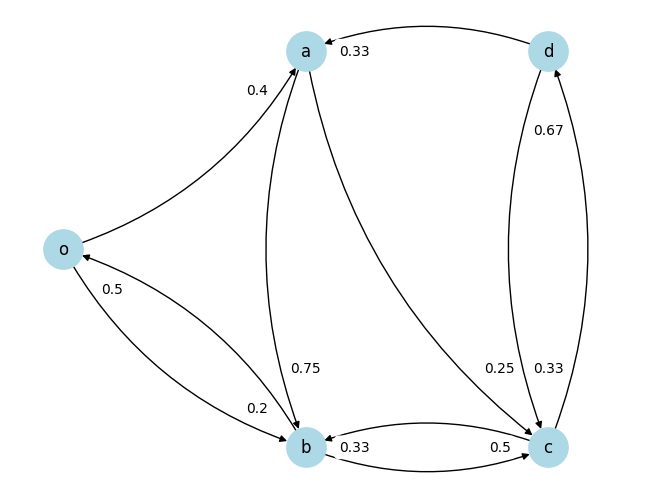

In [2]:
Lambda = [
    [0,   2/5, 1/5, 0,   0  ],
    [0,   0,   3/4, 1/4, 0  ],
    [1/2, 0,   0,   1/2, 0  ],
    [0,   0,   1/3, 0,   2/3],
    [0,   1/3, 0,   1/3, 0  ],
]

G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/5))), ('o', 'b', float("{0:.2f}".format(1/5))), 
                           ('a', 'b', float("{0:.2f}".format(3/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('b', 'o', float("{0:.2f}".format(1/2))), ('b', 'c', float("{0:.2f}".format(1/2))), 
                           ('c', 'b', float("{0:.2f}".format(1/3))), ('c', 'd', float("{0:.2f}".format(2/3))), 
                           ('d', 'a', float("{0:.2f}".format(1/3))), ('d', 'c', float("{0:.2f}".format(1/3)))])
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightblue',  connectionstyle='arc3, rad = 0.2')
labels = {e: G.edges[e]['weight'] for e in G.edges}
val = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')
plt.savefig("imgs/graph1.png", format="png")

### w vector and D, P, Q 

In [3]:
n_nodes = len(G.nodes)

# row sum
w = np.sum(Lambda, axis=1)
w_star = np.max(w)

# P matrix
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda
P_cum = np.cumsum(P, axis=1)

# Q matrix
Q = Lambda/w_star
Q = Q + np.diag(np.ones(len(w)) - np.sum(Q, axis=1))
Q_cum = np.cumsum(Q, axis = 1)

print("Number of nodes: ", n_nodes)
print("\Vector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix Q:\n", Q)
#np.argwhere(Q_cum[0]] > np.random.rand())[0][0]
Q_cum[0]

Number of nodes:  5
\Vector w:
 [0.6   1.    1.    1.    0.667]

Matrix D:
 [[0.6   0.    0.    0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.667]]

Matrix P:
 [[0.    0.667 0.333 0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.    0.5   0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.5   0.    0.5   0.   ]]

Matrix Q:
 [[0.4   0.4   0.2   0.    0.   ]
 [0.    0.    0.75  0.25  0.   ]
 [0.5   0.    0.    0.5   0.   ]
 [0.    0.    0.333 0.    0.667]
 [0.    0.333 0.    0.333 0.333]]


array([0.4, 0.8, 1. , 1. , 1. ])

### Invariant distributin vector pi bar

In [4]:
# Invariant distribution pi_bar (extract dominant eigenvector)
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.185 0.148 0.222 0.222 0.222]


## Problem 1

### 1.a)
#### Question: What is, according to the simulations, the average time it takes a particle that starts in node $a$ to leave the node and then return to it?
##### Random walk simulation method

In [5]:
def simulateRandomWalk(origin, destination, n_simulations):

    # the clock of the simulation will follow rate w_star and matrix Q
    nodes = [0, 1, 2, 3, 4]
    array_return_time = np.zeros(n_simulations, dtype=float)

    for j in range(n_simulations): # iterate over simulations
        pos = []
        # origin node: a (integer representations: 1)
        pos.append(origin) 
        transition_times = []
        transition_times.append(0)
        node_counter = 0
        # w star refers to the global poisson clock
        # If we decide to use global clock, we will work with the Q matrix
        t_next = -np.log(np.random.rand())/w_star

        while True:
            node_counter += 1
            # append index
            pos.append(np.random.choice(nodes, p = Q[pos[node_counter-1], :]))
            transition_times.append(transition_times[node_counter-1] + t_next)
            # if we are back to node a
            if pos[node_counter] == destination: 
                break
            t_next = -np.log(np.random.rand())/w_star


        array_return_time[j] = transition_times[-1]

    avg_return_time = np.mean(array_return_time)
    print("AVG return time: {} s".format(avg_return_time))
    return avg_return_time

In [6]:
simulationAvgTime = simulateRandomWalk(origin=1, destination=1, n_simulations = 10000)

AVG return time: 6.6808763395206014 s


### 1.b)
#### Question: How does the result in a) compare to the theoretical return-time Ea[T+a ]? (Include a description of how this is computed.)
##### Theoretical result comparison with respect to the one given by the simulation 

In [7]:
#define the set S and the remaining nodes R
#we start from node 1 (a) again
node = 1
S = [node]

#define the remaining nodes R
R = [node for node in range(n_nodes) if node not in S]

#restrict P to R x R and obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]

# hat(x) is the solution of the linear system
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),(np.ones(n_nodes-len(S))/hatw))

#hitting time = 0 if the starting node is in S (We have same origin and dest)
hitting_s = np.zeros(n_nodes)
#hitting time = hat(x) for nodes in R
hitting_s[R] = hatx

print('Expected hitting times on a: ',hitting_s)
expected_theoric_a = 1 / w[1] +  np.dot(P[1,:], hitting_s)
print('Expected return time : ',expected_theoric_a)
print("Error simulation",np.linalg.norm(simulationAvgTime - expected_theoric_a))

Expected hitting times on a:  [3.571 0.    5.714 5.857 4.429]
Expected return time :  6.75
Error simulation 0.06912366047939855


### 1.c)
### Question: What is, according to the simulations, the average time it takes to move from node $o$ to node $d$?
##### In order to retrieve the AVG time from node o to node d, we can run again the simulation and change the input parameters

In [8]:
# node o : 0
# node d : 4
simulationAvgTime = simulateRandomWalk(origin=0, destination=4, n_simulations=10000)

AVG return time: 8.820770048969418 s


### 1.d)
### Question: How does the result in c) compare to the theoretical hitting-time Eo[Td]? 
##### Comparison between the result obtained in the previous point with respect to the theoretical hitting time (solve gain linear system)

In [9]:
# Consider node d : 4
node = 4

S = [node]
R = [node for node in range(n_nodes) if node not in S]

hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]

hatx = np.linalg.solve((np.identity(n_nodes - len(S)) - hatP), (np.ones(n_nodes - len(S)) / hatw))

hitting_s = np.zeros(n_nodes)
hitting_s[R] = hatx

expected_od = hitting_s[0]
print("Hitting time: {} time units ".format(expected_od))
print("Error simulation",abs(simulationAvgTime - expected_od))

Hitting time: 8.785714285714285 time units 
Error simulation 0.0350557632551336


### 1.e)
### Question: Interpret the matrix as the weight matrix of a graph G = (V; E; $Λ$), and simulate the French-DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state for every initial condition x(0)?
##### Apply French-DeGroot

The consensus state is: [0.58 0.58 0.58 0.58 0.58]
The consensus value is: 0.5799429173979919


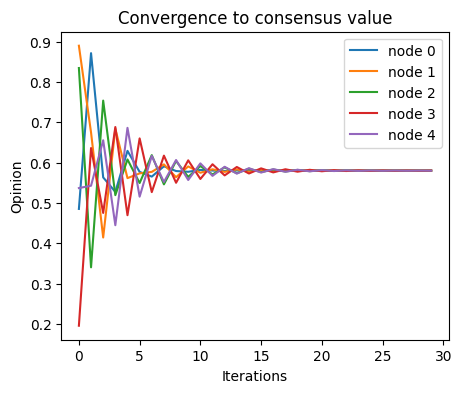

In [10]:
# sufficiently bi number of iterations
n_iter = 30

# Save the evolution of the consensus along iterations
x = np.zeros((len(G.nodes),n_iter))

# Theoretically, as writte in the report, a consensus is reached because the  graph is Strongly connected and Aperiodic
# Since we have to verify the convergence for every initial condition, we se it randomly
x[:,0] = np.random.rand(5)

# evolution
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]
    
x[:,n_iter-1]

# Print consensus at last iteration (when it should be already reached if n_iter is usfficiently big)
print("The consensus state is:", x[:,n_iter-1])

#*****************************
# Check if result obtained by computation is like the expected one bby theory 
#*****************************

# Extract eigenvalues and eigenvectors
values,vectors = np.linalg.eig(P.T)

# selects the eigenvalue 1 and print the eigenvector
for index in [i for i in range(len(G)) if np.isclose(values[i],1)]: 
    # eigenvectors are complex but pi is real (by its property and by eigenvalue = 1)
    pi = vectors[:,index].real  
    pi = pi/np.sum(pi)
    
# Given pi, we multiply it by the initial condition (x(0))
x0 = x[:,0]
consensus_val = pi@x0
print("The consensus value is:", consensus_val)

# NOT REQUIRED:
# plot the record of the consensus vector to have a better look of the convergence
fig = plt.figure(1, figsize=(5,4))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()
ax.set_title("Convergence to consensus value")
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.savefig("imgs\ex1_e_consensus.png", format='png')
plt.show()

### 1.f)
##### Now the initial states of the nodes are expressed as random variables. Calculation and comparison of the consensus variance with respect to the simulation

In [11]:
# set arbitrary the number of simulations
n_sim = 100

# save variance over simulation
err = np.zeros(n_sim)

# Variance from numerical simulation:
for i in range(n_sim):
    # We create initial state randomly with rand function
    # rand values are in [0,1) range with uniform distribution, so mu = 1/2
    x = np.random.rand(5)
    
    # evolution
    for n in range(500):
        x = P @ x
        
    # var = ( (mu - x_mean)^2 ) / n
    # we devide by n later
    err[i] = (1/2 - np.mean(x))**2
    
consensus_var = np.mean(err)
print("The variance of the consensus state is:", consensus_var, "\n")

# ---------------------------
# Variance from theory (pi is characterized by uniform distribution)
# var = (b-a)^2 / 12 = (1-0)^2/12 = 1/12

values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
sigma = 1/12
print("Expected variance:", np.sum(np.square(pi))*sigma)

The variance of the consensus state is: 0.017626626928718695 

Expected variance: 0.017032464563328766


### 1.g)
##### Remove edges (d, a) and (d, c). New Consensus value taking into account that, as 1.f, the initial states of nodes are epressed as random variables. Compute also for this new graph the variance of the consensus.
##### By removing these arcs, in fact $d$ becomes a sink and from $c$ we can not go to other nodes, except from $d$.

C:\Users\garig\AppData\Local\Temp\ipykernel_4252\355635341.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G)


Arbitary initial condition x(0): [0.002 0.843 0.18  0.578 0.953]
The asymptotic state x is: [0.953 0.953 0.953 0.953 0.953]
The variance of the consensus state is: 0.07679935891213345 



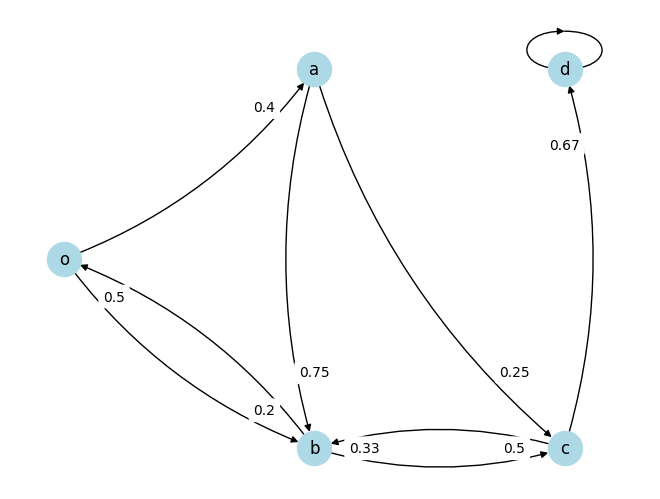

In [12]:
from numpy.linalg import inv, det
# remove edges (d, a) and (d, c)
G.remove_edges_from([('d', 'a'), ('d', 'c')])

#add self loop to d
G.add_weighted_edges_from([('d', 'd', float("{0:.2f}".format(1/10000)))])

pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 600, font_size=12, node_color='lightblue',  connectionstyle='arc3, rad = 0.15')
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')
plt.savefig("imgs\ex1_g_new_graph.png", format='png')

#calculate P
W = nx.adjacency_matrix(G)
W = W.toarray()
W[4][4] = 0.00000001   #self loop weight lowest possible
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
# print(det(D))
P = np.linalg.inv(D) @ W

n_sim = 100
alfa_err = np.zeros(n_sim)


n_iter = 50

#arbitrary initial condition
x = np.random.rand(5)
print('Arbitary initial condition x(0):', x)

for i in range(n_iter):
    x = P @ x
print("The asymptotic state x is:", x)

#with numerical simulations
for i in range(n_sim):
    
    #since rand returns random values in [0,1], mu = 1/2
    x = np.random.rand(5)
    var = np.var(x)
    for n in range(500):
        x = P @ x

    alfa_err[i] = (1/2 - np.mean(x)) * (1/2 - np.mean(x))
    
print("The variance of the consensus state is:", np.mean(alfa_err), "\n")
#only sink in condensation graph. d is not influenced by other opinions but instead influences all the others

### 1.h)
##### Remove edges (c, b) and (d, a).describe and motivate the asymptotic behaviour of the dynamics in terms of the initial condition x(0).
##### $(c, d)$ will form a trapping region

Arbitary initial condition x(0): [0.912 0.654 0.57  0.686 0.177]
Final opinions: [0.412 0.392 0.569 0.177 0.686]


C:\Users\garig\AppData\Local\Temp\ipykernel_4252\370658076.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G)


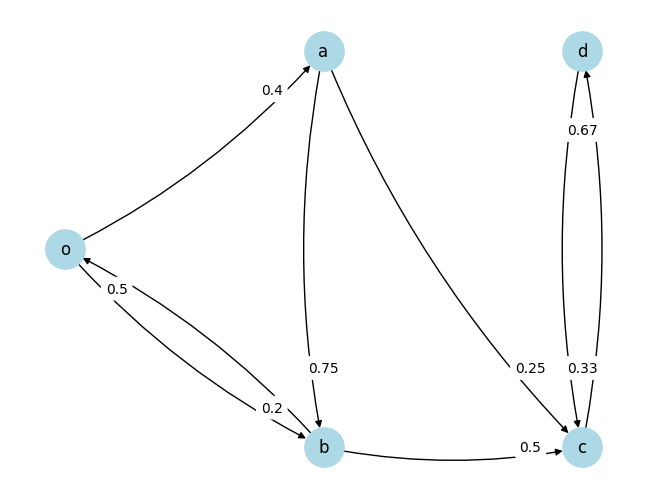

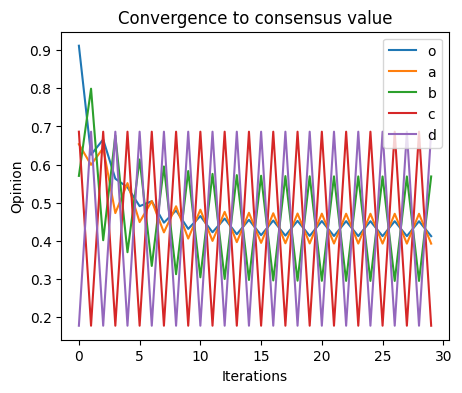

In [13]:
#reconstruct the new graph
G = nx.DiGraph()
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(2/5))), ('o', 'b', float("{0:.2f}".format(1/5))), 
                           ('a', 'b', float("{0:.2f}".format(3/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('b', 'o', float("{0:.2f}".format(1/2))), ('b', 'c', float("{0:.2f}".format(1/2))), 
                           ('c', 'd', float("{0:.2f}".format(2/3))), ('d', 'c', float("{0:.2f}".format(1/3)))])

pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,-2),'d':(2,2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightblue',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
# in this graph there is a periodic trapping set region between nodes c and d
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')
plt.savefig("imgs\ex1_h_new_graph.png", format='png')

#reconstruct P
W = nx.adjacency_matrix(G)
W = W.toarray()
degrees = np.sum(W, axis = 1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

n_iter = 30

x = np.zeros((5,n_iter))
#arbitrary initial condition
x[:,0] = np.random.rand(5)
print('Arbitary initial condition x(0):', x[:,0])

# evolve the states
for t in range(1,n_iter):
    x[:,t] = P @ x[:,t-1]

print("Final opinions:", x[:,n_iter-1])

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = plt.subplot(111)
node_names = ['o', 'a', 'b', 'c', 'd']
  
for node in range(5):
    op = x[node,:]
    ax.plot(range(n_iter), op, label=f'{node_names[node]}')
      
ax.legend()
ax.set_title("Convergence to consensus value")
plt.xlabel('Iterations')
plt.ylabel('Opinion')
plt.savefig("imgs/ex1_h.png", format='png')
plt.show()

***
## Problem 2

### 2.a) Particle perspective
##### 100 particles starting in node a, calculate AVG return time to node a. Compare the result with the theoretical one found in Problem 1 

In [14]:
# 100 particles 
particles = np.array(range(100)).astype(np.int32)
# same simulation method as before but with more simulations
simulationAvgTime = simulateRandomWalk(origin=1, destination=1, n_simulations= len(particles)*1000)
print(f'Simulation time: {simulationAvgTime} | Expected time: {expected_theoric_a}')
print("Error simulation",abs(simulationAvgTime - expected_theoric_a))

AVG return time: 6.756814353632101 s
Simulation time: 6.756814353632101 | Expected time: 6.75
Error simulation 0.006814353632100811


### 2.b) Node perspective
##### 100 particles starting in node o, system simulated for 60 t units. Calculate AVG number of particles in the different nodes at the end of the simulation. Plot particles position over the iterations. 

In [71]:
# stating with 100 particles in node 'o'
n_particles=100  # Equal to the rate
time_units = 60
# all starting in o
hist_nodes = np.array([[100, 0, 0, 0, 0 ]], dtype=float)

n_nodes = np.zeros(len(G.nodes), dtype = float)
n_nodes[0] = n_particles
P_nodes = n_nodes/n_particles
P_nodes_cum = np.cumsum(P_nodes)
P_nodes, P_nodes_cum

(array([1., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1.]))

In [72]:
transition_times = []
transition_times.append(0)

#first iteration we move the particles from node o
t_next = -np.log(np.random.rand())/(n_particles*w_star)
i = 0

timeSeq = []
timeSeq.append(0)

while transition_times[i] < time_units:
    i += 1

    transition_times.append(transition_times[i-1] + t_next )
    timeSeq.append(transition_times[-1])

    start_index = np.argwhere(P_nodes_cum > np.random.rand())[0][0]
    dest_index = np.argwhere(Q_cum[start_index] >= np.random.rand())[0][0]

    n_nodes[dest_index] += 1
    n_nodes[start_index] -= 1 
    
    hist_nodes = np.concatenate((hist_nodes, [n_nodes]), axis = 0)

    P_nodes=n_nodes/n_particles
    P_nodes_cum = np.cumsum(P_nodes)
    
    # at iteration t, the poiss clock will take the number of particles in the node times w of the node
    t_next = -np.log(np.random.rand())/(n_particles*w_star)
    
avg_particles = {}
for nodes, avg_value in zip(G.nodes, np.average(hist_nodes, axis=0)):
    avg_particles[nodes] = round(avg_value, 2)

print("Particles per node at final step: ", avg_particles)
#print("Average number of particles in every node pi_bar: ", 100*pi_bar)

Particles per node at final step:  {'o': 20.86, 'a': 15.38, 'b': 22.05, 'c': 21.04, 'd': 20.67}
Average number of particles in every node pi_bar:  [18.519 14.815 22.222 22.222 22.222]


##### Plot:

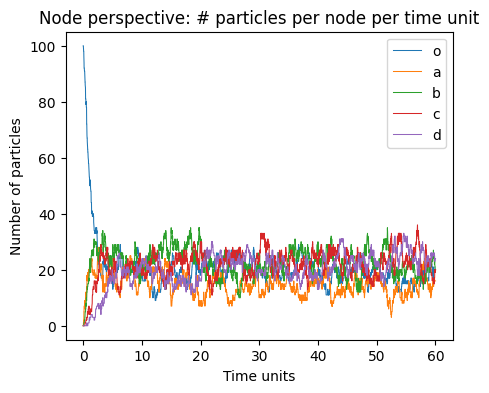

In [70]:
fig, ax = plt.subplots(figsize=(5,4)) 
labels = dict(enumerate(G.nodes))

for i in range(len(G)):
    ax.plot(timeSeq, hist_nodes[:, i], label=labels[i], linewidth=0.75)
    
ax.legend()
ax.set_title("Node perspective: # particles per node per time unit")
plt.xlabel('Time units')
plt.ylabel('Number of particles')
plt.savefig("imgs/ex2_b.png", format='png')
plt.show()

***
## Problem 3

### 3.a) 
##### Scenario i) proportional rate 
#####
##### ---> find the highest rate that the system can handle without blowing up  

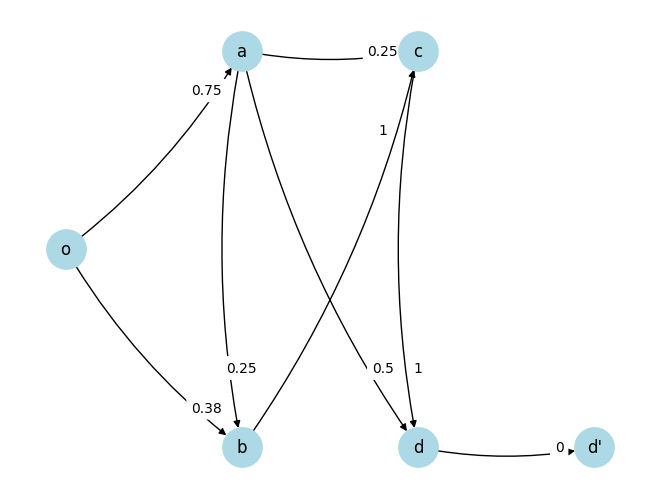

In [6]:
# draw graph
G = nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d', "d'"])
G.add_weighted_edges_from([('o', 'a', float("{0:.2f}".format(3/4))), ('o', 'b', float("{0:.2f}".format(3/8))), 
                           ('a', 'b', float("{0:.2f}".format(1/4))), ('a', 'c', float("{0:.2f}".format(1/4))), 
                           ('a', 'd', float("{0:.2f}".format(2/4))), ('b', 'c',1), ('c','d',1), ('d', "d'", 0)])
pos = nx.spring_layout(G)
pos={'o':(0,0),'a':(1,2),'b':(1,-2),'c':(2,2),'d':(2,-2), "d'":(3, -2)}
nx.draw(G, pos=pos, with_labels=True, node_size = 800, font_size=12, node_color='lightblue',  connectionstyle='arc3, rad = 0.1')
labels = {e: G.edges[e]['weight'] for e in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.20, rotate = False, horizontalalignment ='center')

plt.savefig('imgs/graph3.png', format='png')
Lambda = [ [0,  3/4, 3/8, 0,   0],
                [0,  0,   1/4, 1/4, 2/4],
                [0,  0,   0,   1,   0],
                [0,  0,   0,   0,   1],
                [0,  0,   0,   0,   0],
]

In [13]:
w = np.sum(Lambda, axis=1)
w[4]=2
w_star = np.max(w)

# compute the off-diagonal part of Q
Q = Lambda/w_star
# add the diagonal part
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))

D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# compute dominant eigenvector
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)


pi_bar= [0. 0. 0. 0. 1.]


In [24]:
axis_x = [0]
# keep track of particles per node
axis_y0 = [0] # o
axis_y1 = [0] # a
axis_y2 = [0] # b
axis_y3 = [0] # c
axis_y4 = [0] # d
n_states=5
array_pos_nodi = [0]*n_states # array with final number for particles

num_particles = 100

max_time_units = 60
time = 0

i=0
# initial lambda: input rate = 1 (we will test other values for question b)
# --> [1, 5, 10, 50, 100]
input_rate = 100
while time<60:
  # generation of the clocks, one for each node
  t_next_nodes=[]
  if array_pos_nodi[0] > 0:  # clock for o
    t_next_nodes.append(-np.log(np.random.rand())/(axis_y0[-1] * np.array(w[0])))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[1] > 0:  # clock for a
    t_next_nodes.append(-np.log(np.random.rand())/(axis_y1[-1] * np.array(w[1])))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[2] > 0:  # clock for b
    t_next_nodes.append(-np.log(np.random.rand())/(axis_y2[-1] * np.array(w[2])))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[3] > 0:  # clock for c
    t_next_nodes.append(-np.log(np.random.rand())/(axis_y3[-1] * np.array(w[3])))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[4] > 0:  # clock for d
    t_next_nodes.append(-np.log(np.random.rand())/(axis_y4[-1] * np.array(w[4])))
  else:
    t_next_nodes.append(np.inf)
  # clock per dummy node di input -> 5
  t_next_nodes.append(-np.log(np.random.rand())/input_rate)

  node_consid = np.argmin(t_next_nodes)
  time += t_next_nodes[node_consid]

  if time == 60:
      break
  # input of a particle
  if node_consid == 5:  
    array_pos_nodi[0]=array_pos_nodi[0]+1
  else:    
    # It is removed the particle from the node because it is moving
    array_pos_nodi[node_consid] -= 1  

    #if the node d has been chosen, the particle is removed from the system
    if node_consid != 4:
      node_succ = np.random.choice(n_states, p=P[node_consid, :])
      array_pos_nodi[node_succ] += 1

  axis_y0.append(array_pos_nodi[0])
  axis_y1.append(array_pos_nodi[1])
  axis_y2.append(array_pos_nodi[2])
  axis_y3.append(array_pos_nodi[3])
  axis_y4.append(array_pos_nodi[4])
  axis_x.append(time)

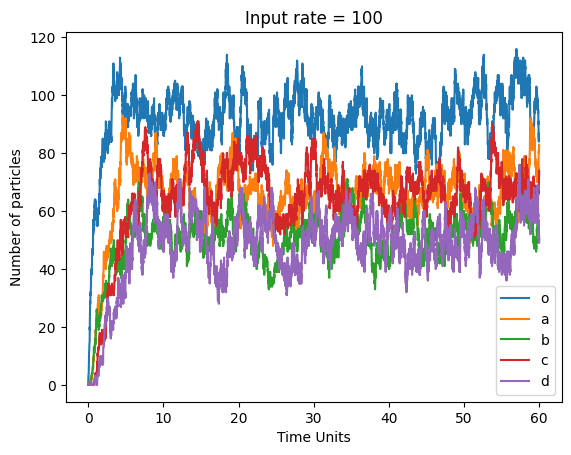

In [25]:
plt.plot(axis_x, axis_y0, label = "o")
plt.plot(axis_x, axis_y1, label = "a")
plt.plot(axis_x, axis_y2, label = "b")
plt.plot(axis_x, axis_y3, label = "c")
plt.plot(axis_x, axis_y4, label = "d")

plt.title(f'Input rate = {input_rate}')
plt.xlabel("Time Units")
plt.ylabel("Number of particles")

plt.legend()
plt.savefig(f"imgs/ex3_a_{input_rate}.png", format='png')
plt.show()


### 3.b)
##### Fixed clock rate, one for every node as before


In [45]:
w

array([1.125, 1.   , 1.   , 1.   , 2.   ])

In [104]:
axis_x = [0]
axis_y0 = [0]
axis_y1 = [0]
axis_y2 = [0]
axis_y3 = [0]
axis_y4 = [0]
n_states=5
array_pos_nodi = [0]*n_states

num_particles = 100

max_time_units = 60
time = 0

i=0
input_rate = 1.5
#input_rate = 0.7
#input_rate = 1
#input_rate = 1.25
#input_rate = 1.5


while time<60:
  # generation of the clocks, one for each node
  t_next_nodes=[]
  if array_pos_nodi[0] > 0:  # clock for o
    t_next_nodes.append(-np.log(np.random.rand())/(w[0]))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[1] > 0:  # clock for a
    t_next_nodes.append(-np.log(np.random.rand())/(w[1]))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[2] > 0:  # clock for b
    t_next_nodes.append(-np.log(np.random.rand())/(w[2]))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[3] > 0:  # clock for c
    t_next_nodes.append(-np.log(np.random.rand())/(w[3]))
  else:
    t_next_nodes.append(np.inf)
  if array_pos_nodi[4] > 0:  # clock for d
    t_next_nodes.append(-np.log(np.random.rand())/(w[4]))
  else:
    t_next_nodes.append(np.inf)
  
  t_next_nodes.append(-np.log(np.random.rand())/input_rate)

  node_consid = np.argmin(t_next_nodes)
  time += t_next_nodes[node_consid]

  if time == 60:
      break

  # input of a particle
  if node_consid == 5:  
    array_pos_nodi[0]=array_pos_nodi[0]+1
  else:    
    # It is removed the particle from the node because it is moving
    array_pos_nodi[node_consid] -= 1

    #if the node d has been chosen, the particle is removed from the system
    if node_consid != 4:  
      node_succ = np.random.choice(n_states, p=P[node_consid, :])
      array_pos_nodi[node_succ] += 1

  axis_y0.append(array_pos_nodi[0])
  axis_y1.append(array_pos_nodi[1])
  axis_y2.append(array_pos_nodi[2])
  axis_y3.append(array_pos_nodi[3])
  axis_y4.append(array_pos_nodi[4])
  axis_x.append(time)

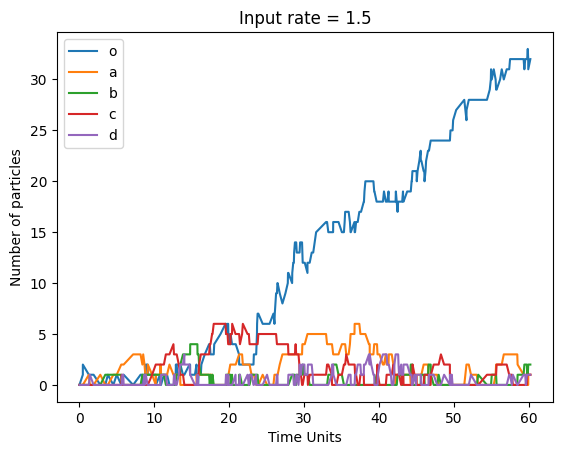

In [105]:
plt.plot(axis_x, axis_y0, label = "o")
plt.plot(axis_x, axis_y1, label = "a")
plt.plot(axis_x, axis_y2, label = "b")
plt.plot(axis_x, axis_y3, label = "c")
plt.plot(axis_x, axis_y4, label = "d")

plt.title(f'Input rate = {input_rate}')
plt.xlabel("Time Units")
plt.ylabel("Number of particles")
plt.legend()
plt.savefig(f"imgs/ex3_b_{input_rate}.png", format='png')
plt.show()